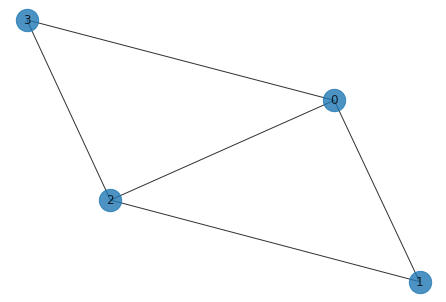

In [136]:
import networkx as nx
graph = nx.Graph()
graph.add_nodes_from([0,1,2,3])
graph.add_edges_from([(0,1), (0,2), (0,3), (1,2), (2,3)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

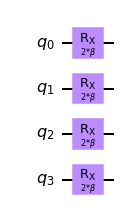

In [137]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2*beta, i)
    
qc_mix.draw("mpl")

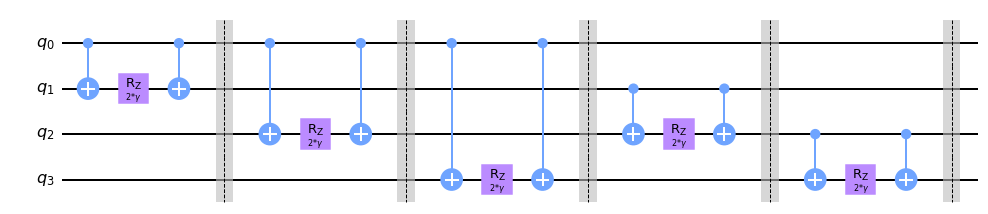

In [138]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(graph.edges()):
    qc_p.rzz(2*gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw("mpl")

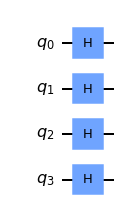

In [139]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)
    
qc_0.draw("mpl")

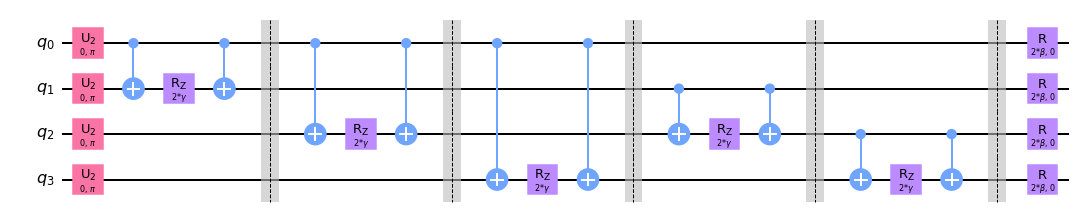

In [140]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw("mpl")

In [141]:
def maxcut_obj(solution, graph):
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj

In [142]:
def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [143]:
def create_qaoa_circ(graph, theta):
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2
    beta = theta[:n_layers]
    gamma = theta[n_layers:]
    
    qc = QuantumCircuit(nqubits)
    qc.h(range(nqubits))
    
    for layer_index in range(n_layers):
        for pair in list(graph.edges()):
            qc.rzz(2*gamma[layer_index], pair[0], pair[1])
            
        for qubit in range(nqubits):
            qc.rx(2*beta[layer_index], qubit)
            
    qc.measure_all()
    return qc

In [144]:
def get_expectation(graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=9, nshots=512).result().get_counts()
        return compute_expectation(counts, graph)
    
    return execute_circ

## Without Error Filtering Method

In [145]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -3.13671875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 28
  status: 1
 success: True
       x: array([2.15793797, 1.03690755])

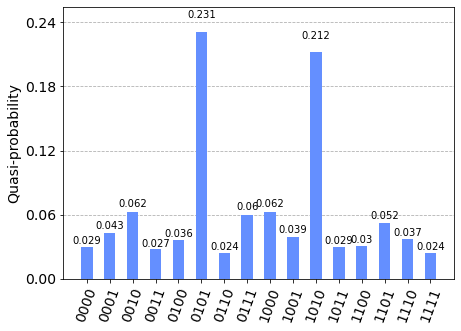

In [146]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram, plot_distribution

qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=9).result().get_counts()
#plot_histogram(counts)
plot_distribution(counts)

## With Error Filtering Method

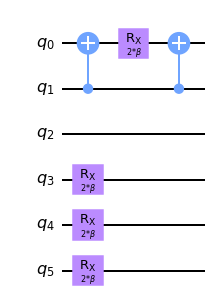

In [147]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

adjacency = nx.adjacency_matrix(graph).todense()

N_QUBITS = 4
logical_qubits = 1
ancilla_qubits = 1
TOT_QUBITS = N_QUBITS + logical_qubits + ancilla_qubits

beta = Parameter("$\\beta$")
qc_mix_EF = QuantumCircuit(TOT_QUBITS)

qc_mix_EF.cx(1,0)
qc_mix_EF.rx(2*beta, 0)
qc_mix_EF.cx(1,0)

for i in range(N_QUBITS-1):
    qc_mix_EF.rx(2*beta, i+3)
    
qc_mix_EF.draw("mpl")

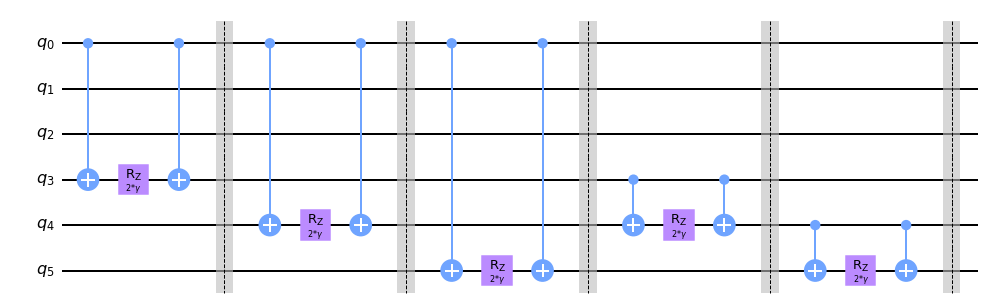

In [148]:
gamma = Parameter("$\\gamma$")
qc_p_EF = QuantumCircuit(TOT_QUBITS)
for pair in list(graph.edges()):
    if pair[0]==0:
        qc_p_EF.rzz(2*gamma, pair[0], pair[1]+2)
    else:
        qc_p_EF.rzz(2*gamma, pair[0]+2, pair[1]+2)
    qc_p_EF.barrier()
    
qc_p_EF.decompose().draw("mpl")

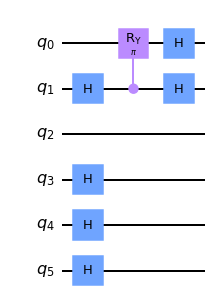

In [149]:
import math as ma

qc_0_EF = QuantumCircuit(TOT_QUBITS)

qc_0_EF.h(1)
qc_0_EF.cry(ma.pi, 1, 0)
qc_0_EF.h([0,1])

for i in range(N_QUBITS-1):
    qc_0_EF.h(i+3)
    
qc_0_EF.draw("mpl")

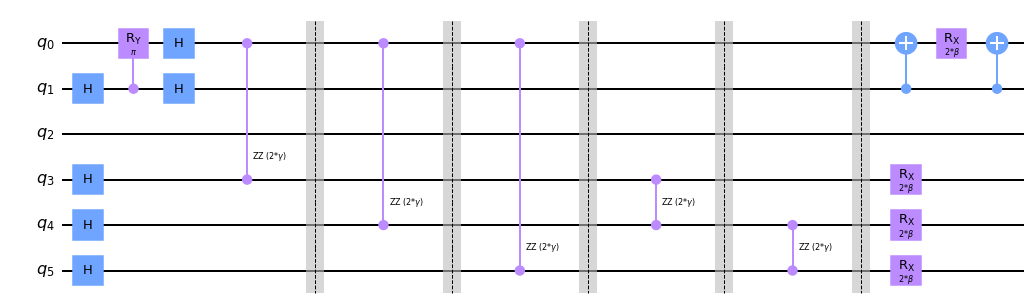

In [157]:
qc_qaoa_EF = QuantumCircuit(TOT_QUBITS)
qc_qaoa_EF.append(qc_0_EF, range(TOT_QUBITS))
qc_qaoa_EF.append(qc_p_EF, range(TOT_QUBITS))
qc_qaoa_EF.append(qc_mix_EF, range(TOT_QUBITS))

qc_qaoa_EF.decompose().draw("mpl")

In [151]:
def maxcut_obj_EF(solution, graph):
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj

In [152]:
def compute_expectation_EF(counts, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj_EF(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [153]:
def create_qaoa_EF_circ(graph, theta):
    nqubits = len(graph.nodes())
    tqubits = nqubits + 2
    n_layers = len(theta)//2
    beta = theta[:n_layers]
    gamma = theta[n_layers:]
    
    qc = QuantumCircuit(tqubits)
    
    # Initialization
    import math as ma
    qc.h(1)
    qc.cry(ma.pi,1,0)
    qc.h([0,1])
    for i in range(nqubits-1):
        qc.h(i+3)
    
    for layer_index in range(n_layers):
        # Problem Hamiltonian
        for pair in list(graph.edges()):
            if pair[0] == 0:
                qc.rzz(2*gamma[layer_index], pair[0], pair[1]+2)
            else:
                qc.rzz(2*gamma[layer_index], pair[0]+2, pair[1]+2)
                
        # Mixing Hamiltonian
        qc.cx(1,0)
        qc.rx(2*beta[layer_index], 0)
        qc.cx(1,0)
        for i in range(nqubits-1):
            qc.rx(2*beta[layer_index], i+3)
            
    # Error Filtering Process
    qc.cx(0,2)
    qc.cx(1,2)
            
    qc.measure_all()
    return qc

In [154]:
def get_expectation_EF(graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_EF_circ(theta):
        qc = create_qaoa_EF_circ(graph, theta)
        qc_tr = transpile(qc, backend)
        counts = backend.run(qc_tr, seed_simulator=9, nshots=512).result().get_counts()
        
        counts_pp = {}
        for string, count in counts.items():
            if string[4]==string[5] and string[3]=='0':
                counts_pp[string[0:3]+string[4]] = count        
        
        return compute_expectation_EF(counts_pp, graph)
    
    return execute_EF_circ

In [155]:
from scipy.optimize import minimize
expectation = get_expectation_EF(graph)
res = minimize(expectation, [1.0, 1.0], method='COBYLA')
res

     fun: -3.20682302771855
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 33
  status: 1
 success: True
       x: array([0.81113862, 1.0907125 ])

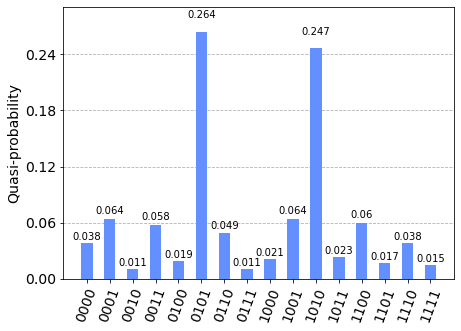

In [156]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram, plot_distribution

qc_res_EF = transpile(create_qaoa_EF_circ(graph, res.x), backend)
counts = backend.run(qc_res_EF, seed_simulator=9).result().get_counts()

counts_pp = {}
for string, count in counts.items():
    if string[4]==string[5] and string[3]=='0':
        counts_pp[string[0:3]+string[4]] = count  
        
#print(counts_pp)
plot_distribution(counts_pp)

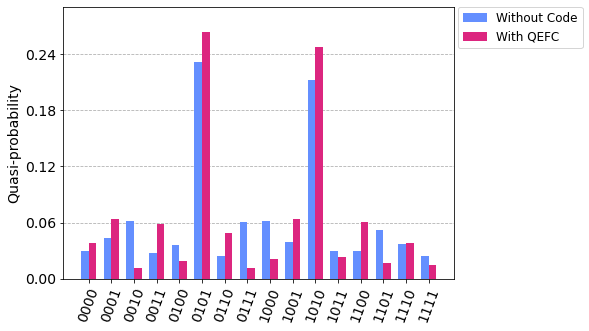

In [2]:
from qiskit.visualization import plot_histogram

original_prob = {'0000': 0.029, '0001': 0.043, '0010': 0.062, '0011': 0.027, 
 '0100': 0.036, '0101': 0.231, '0110': 0.024, '0111': 0.06, 
 '1000': 0.062, '1001': 0.039, '1010': 0.212, '1011': 0.029, 
 '1100': 0.03, '1101': 0.052, '1110': 0.037, '1111': 0.024}

EF_prob = {'0000': 0.038, '0001': 0.064, '0010': 0.011, '0011': 0.058, 
 '0100': 0.019, '0101': 0.264, '0110': 0.049, '0111': 0.011, 
 '1000': 0.021, '1001': 0.064, '1010': 0.247, '1011': 0.023, 
 '1100': 0.06, '1101': 0.017, '1110': 0.038, '1111': 0.015}

#title_qas = "Max-cut with QAOA"
legend = ["Without Code", "With QEFC"]
plot_histogram([original_prob, EF_prob], 
               legend=legend, bar_labels=False)